# Violence Detection 


## done by 

# Amaan Mohamed K 20BAI1081
# Sarath Krishna C 20BAI1119

In [62]:
import tensorflow as tf

In [63]:
from IPython.display import HTML
from base64 import b64encode

In [64]:
PROJECT_DIR = r'C:\Users\amaan\OneDrive\Desktop\Data'

## Dataset used: https://www.kaggle.com/datasets/mohamedmustafa/real-life-violence-situations-dataset

### Our Dataset Contains 1000 Violence and 1000 non-violence videos collected from youtube videos, violence videos in our dataset contain many real street fights situations in several environments and conditions also non-violence videos from our dataset are collected from many different human actions like sports, eating, walking …etc.

In [65]:
!ls {PROJECT_DIR}

NonViolence
Violence


# We are doing violence detection using Mobile Net v2. Each class has 1000 videos. We are using 500 videos from each class due to RAM and Storage constraints.

In [66]:
def play(filename):
    html = ''
    video = open(filename,'rb').read()
    src = 'data:video/mp4;base64,' + b64encode(video).decode()
    html += '<video width=640 muted controls autoplay loop><source src="%s" type="video/mp4"></video>' % src 
    return HTML(html)

In [92]:
# Sample videos displayed below.

In [67]:
play(r'C:\Users\amaan\OneDrive\Desktop\Data/Violence/V_213.mp4')

In [68]:
play(r'C:\Users\amaan\OneDrive\Desktop\Data/NonViolence/NV_247.mp4')

In [69]:
!pip install imgaug

In [93]:
import cv2
import os
import imageio
import imgaug.augmenters as iaa
import imgaug as ia

IMG_SIZE = 128
ColorChannels = 3

# The video is broken down into frames which is analysed to detect whether it is violence or non violence.

def video_to_frames(video):
    vidcap = cv2.VideoCapture(video)
    
    import math
    rate = math.floor(vidcap.get(3))
    count = 0
    
    ImageFrames = []
    while vidcap.isOpened():
        ID = vidcap.get(1)
        success, image = vidcap.read()
        
        if success:
            # skipping frames to avoid duplications 
            if (ID % 7 == 0):
                flip = iaa.Fliplr(1.0)
                zoom = iaa.Affine(scale=1.3)
                random_brightness = iaa.Multiply((1, 1.3))
                rotate = iaa.Affine(rotate=(-25, 25))
                
                image_aug = flip(image = image)
                image_aug = random_brightness(image = image_aug)
                image_aug = zoom(image = image_aug)
                image_aug = rotate(image = image_aug)
                
                rgb_img = cv2.cvtColor(image_aug, cv2.COLOR_BGR2RGB)
                resized = cv2.resize(rgb_img, (IMG_SIZE, IMG_SIZE))
                ImageFrames.append(resized)
                
            count += 1
        else:
            break
    
    vidcap.release()
    
    return ImageFrames

In [71]:
from tqdm import tqdm

VideoDataDir = PROJECT_DIR 
print('We have \n{} Violence videos \n{} NonViolence videos'.format(
              len(os.listdir(VideoDataDir + '/Violence')), 
              len(os.listdir(VideoDataDir + '/NonViolence'))))

X_original = []
y_original = []

CLASSES = ["NonViolence", "Violence"]

for category in os.listdir(VideoDataDir):
    path = os.path.join(VideoDataDir, category)
    class_num = CLASSES.index(category)
    for i, video in enumerate(tqdm(os.listdir(path)[0:500])): #500 out of 1000 images for each class is being used.
        frames = video_to_frames(path + '/' + video)
        for j, frame in enumerate(frames):
            X_original.append(frame)
            y_original.append(class_num)

  0%|                                                                                          | 0/500 [00:00<?, ?it/s]

We have 
1000 Violence videos 
1000 NonViolence videos


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [05:43<00:00,  1.46it/s]


In [72]:
import numpy as np
X_original = np.array(X_original).reshape(-1 , IMG_SIZE * IMG_SIZE * 3)
y_original = np.array(y_original)
len(X_original)

19512

In [73]:
from sklearn.model_selection import StratifiedShuffleSplit

stratified_sample = StratifiedShuffleSplit(n_splits=2, test_size=0.3, random_state=73)

for train_index, test_index in stratified_sample.split(X_original, y_original):
    X_train, X_test = X_original[train_index], X_original[test_index] # dividing the samples into train and test.
    y_train, y_test = y_original[train_index], y_original[test_index]

X_train_nn = X_train.reshape(-1, IMG_SIZE, IMG_SIZE, 3) / 255
X_test_nn = X_test.reshape(-1, IMG_SIZE, IMG_SIZE, 3) / 255

In [74]:
!pip install imutils


In [75]:
import cv2
import os
import numpy as np
import pickle
import matplotlib
matplotlib.use("Agg")

from keras.layers import Input
from keras.models import Model
from keras.layers.core import Dropout,Flatten,Dense

import matplotlib.pyplot as plt

In [76]:
tf.random.set_seed(73)
TPU_INIT = False

# TPU is used to load the model.

if TPU_INIT:
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
        tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)
    
    except ValueError:
        raise BaseException('ERROR: Not connected to a TPU runtime!')
else:
    !nvidia-smi
;    
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.10.0


'nvidia-smi' is not recognized as an internal or external command,
operable program or batch file.


In [77]:
epochs = 5

from keras import regularizers
kernel_regularizer = regularizers.l2(0.0001)

from keras.applications import MobileNetV2 # using MobileNetV2

def load_layers():
    input_tensor = Input(shape=(IMG_SIZE, IMG_SIZE, ColorChannels))
    baseModel = MobileNetV2(pooling='avg',
                            include_top=False, 
                            input_tensor=input_tensor)
    
    headModel = baseModel.output   
    headModel = Dense(1, activation="sigmoid")(headModel)
    model = Model(inputs=baseModel.input, outputs=headModel)

    for layer in baseModel.layers:
        layer.trainable = False

    print("Compiling model...")
    model.compile(loss="binary_crossentropy",
                    optimizer='adam',              # adam optimizer usually gives best results.
                    metrics=["accuracy"])

    return model

if TPU_INIT:
    with tpu_strategy.scope():
        model = load_layers()
else:
    model = load_layers()

model.summary()

Compiling model...
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['input_2[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 64, 64, 32)   0           ['bn_Con

In [78]:
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping, ReduceLROnPlateau

patience = 3

start_lr = 0.00001
min_lr = 0.00001
max_lr = 0.00005

batch_size = 4

if TPU_INIT:
    max_lr = max_lr * tpu_strategy.num_replicas_in_sync
    batch_size = batch_size * tpu_strategy.num_replicas_in_sync

rampup_epochs = 5
sustain_epochs = 0
exp_decay = .8

def lrfn(epoch):
    if epoch < rampup_epochs:
        return (max_lr - start_lr)/rampup_epochs * epoch + start_lr
    elif epoch < rampup_epochs + sustain_epochs:
        return max_lr
    else:
        return (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr


class myCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if ((logs.get('accuracy')>=0.999)):  # stop epochs if accuracy goes more than 0.999
            print("\nLimits Reached cancelling training!")
            self.model.stop_training = True

In [79]:
end_callback = myCallback()

lr_callback = LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=False)

early_stopping = EarlyStopping(patience = patience, monitor='val_loss',
                                 mode='min', restore_best_weights=True, 
                                 verbose = 1, min_delta = .00075)



lr_plat = ReduceLROnPlateau(patience = 2, mode = 'min')

os.system('rm -rf ./logs/')

import datetime
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir = log_dir, write_graph=True, histogram_freq=1)

checkpoint_filepath = 'ModelWeights.h5' # savings the weight values to ModelWeights.h5 file.

model_checkpoints = ModelCheckpoint(filepath=checkpoint_filepath,
                                        save_weights_only=True,
                                        monitor='val_loss',
                                        mode='min',
                                        verbose = 1,
                                        save_best_only=True)


callbacks = [end_callback, lr_callback, model_checkpoints, tensorboard_callback, early_stopping, lr_plat]

if TPU_INIT:
    callbacks = [end_callback, lr_callback, model_checkpoints, early_stopping, lr_plat]

In [80]:
print('Training head...')
#model.load_weights('./Model_Weights.h5')

history = model.fit(X_train_nn ,y_train, epochs=epochs,
                        callbacks=callbacks,
                        validation_data = (X_test_nn, y_test),
                        batch_size=batch_size)

print('\nRestoring best Weights for MobileNetV2')
model.load_weights(checkpoint_filepath)  # Training the model.

Training head...
Epoch 1/5
3415/3415 [==============================] - ETA: 0s - loss: 0.8588 - accuracy: 0.5143
Epoch 1: val_loss improved from inf to 0.72029, saving model to ModelWeights.h5
3415/3415 [==============================] - 298s 85ms/step - loss: 0.8588 - accuracy: 0.5143 - val_loss: 0.7203 - val_accuracy: 0.5967 - lr: 1.0000e-05
Epoch 2/5
3414/3415 [============================>.] - ETA: 0s - loss: 0.5712 - accuracy: 0.7045
Epoch 2: val_loss improved from 0.72029 to 0.48041, saving model to ModelWeights.h5
3415/3415 [==============================] - 282s 83ms/step - loss: 0.5712 - accuracy: 0.7045 - val_loss: 0.4804 - val_accuracy: 0.7726 - lr: 1.8000e-05
Epoch 3/5
3414/3415 [============================>.] - ETA: 0s - loss: 0.4104 - accuracy: 0.8202
Epoch 3: val_loss improved from 0.48041 to 0.36622, saving model to ModelWeights.h5
3415/3415 [==============================] - 274s 80ms/step - loss: 0.4103 - accuracy: 0.8203 - val_loss: 0.3662 - val_accuracy: 0.8379 - 

In [81]:
%matplotlib inline

def print_graph(item, index, history):
    plt.figure()
    train_values = history.history[item][0:index]
    plt.plot(train_values)
    test_values = history.history['val_' + item][0:index]
    plt.plot(test_values)
    plt.legend(['training','validation'])
    plt.title('Training and validation '+ item)  
    plt.xlabel('epoch')
    plt.show()
    plot = '{}.png'.format(item)
    plt.savefig(plot)


def get_best_epoch(test_loss, history):
    for key, item in enumerate(history.history.items()):
        (name, arr) = item
        if name == 'val_loss':
            for i in range(len(arr)):
                if round(test_loss, 2) == round(arr[i], 2):
                    return i
                
def model_summary(model, history):
    print('---'*30)
    test_loss, test_accuracy = model.evaluate(X_test_nn, y_test, verbose=0)

    if history:
        index = get_best_epoch(test_loss, history)
        print('Best Epochs: ', index)

        train_accuracy = history.history['accuracy'][index]
        train_loss = history.history['loss'][index]

        print('Accuracy on train:',train_accuracy,'\tLoss on train:',train_loss) # displaying accuracy and loss on train and test.
        print('Accuracy on test:',test_accuracy,'\tLoss on test:',test_loss)
        print_graph('loss', index, history)
        print_graph('accuracy', index, history)
        print('---'*30)

# Plotting graphs to see the drop in loss values and increase in the training accuracy.

------------------------------------------------------------------------------------------
Best Epochs:  4
Accuracy on train: 0.8860008716583252 	Loss on train: 0.2847965359687805
Accuracy on test: 0.8911855220794678 	Loss on test: 0.2704268991947174


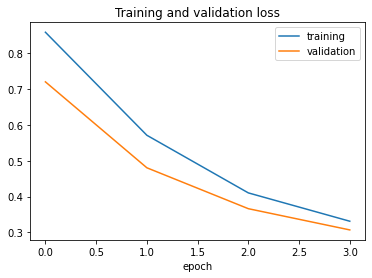

<Figure size 432x288 with 0 Axes>

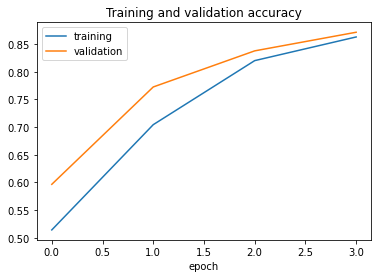

------------------------------------------------------------------------------------------


<Figure size 432x288 with 0 Axes>

In [82]:
model_summary(model, history)


In [83]:
print("Evaluating network...")
predictions = model.predict(X_test_nn)
preds = predictions > 0.6  # only classifies into a category if the prediction is more than 60% confident. 0.6 is chosen so the model will be more accurate.

Evaluating network...
183/183 [==============================] - 51s 273ms/step


<ipython-input-84-de97b9dafb2a>:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  n_correct = np.int((corr_pred[0][0] + corr_pred[1][1]))
<ipython-input-84-de97b9dafb2a>:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated

> Correct Predictions: 5208
> Wrong Predictions: 646


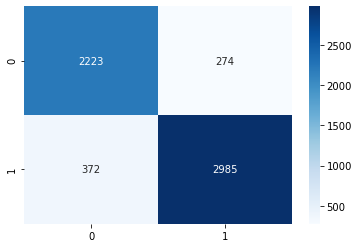

              precision    recall  f1-score   support

 NonViolence       0.86      0.89      0.87      2497
    Violence       0.92      0.89      0.90      3357

    accuracy                           0.89      5854
   macro avg       0.89      0.89      0.89      5854
weighted avg       0.89      0.89      0.89      5854



In [84]:
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score, plot_roc_curve, accuracy_score, classification_report, confusion_matrix
corr_pred = metrics.confusion_matrix(y_test, preds)

n_correct = np.int((corr_pred[0][0] + corr_pred[1][1]))
print('> Correct Predictions:', n_correct)
n_wrongs = np.int((corr_pred[0][1] + (corr_pred[1][0])))
print('> Wrong Predictions:', n_wrongs)

sns.heatmap(corr_pred,annot=True, fmt="d",cmap="Blues")   # Correlation heatmap to show the correct and wrong predictions.
plt.show()

print(metrics.classification_report(y_test, preds, 
                           target_names=["NonViolence", "Violence"]))

# Just after 5 epochs, the accuracy is at 89%.

In [85]:
args_model = "model.h5"
model.save(args_model)

In [86]:
import numpy as np
import argparse
import pickle
import cv2
import os
import time
from keras.models import load_model
from collections import deque

def print_results(video, limit=None):
        fig=plt.figure(figsize=(16, 30))
        if not os.path.exists('output'):   # Displaying the outputs by using the weights model.
            os.mkdir('output')

        print("Loading model ...")
        model = load_model('./model.h5')
        Q = deque(maxlen=128)

        vs = cv2.VideoCapture(video)
        writer = None
        (W, H) = (None, None)
        count = 0     
        while True:
                (grabbed, frame) = vs.read()
                ID = vs.get(1)
                if not grabbed:
                    break
                try:
                    if (ID % 7 == 0):
                        count = count + 1
                        n_frames = len(frame)
                        
                        if W is None or H is None:
                            (H, W) = frame.shape[:2]

                        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                        output = cv2.resize(frame, (512, 360)).copy()
                        frame = cv2.resize(frame, (128, 128)).astype("float32")
                        frame = frame.reshape(IMG_SIZE, IMG_SIZE, 3) / 255
                        preds = model.predict(np.expand_dims(frame, axis=0))[0]
                        Q.append(preds)

                        results = np.array(Q).mean(axis=0)
                        i = (preds > 0.6)[0] #np.argmax(results)

                        label = i

                        text = "Violence: {}".format(label)
                        #print('prediction:', text)
                        file = open("output.txt",'w')
                        file.write(text)
                        file.close()

                        color = (0, 255, 0)

                        if label:
                            color = (255, 0, 0) 
                        else:
                            color = (0, 255, 0)

                        cv2.putText(output, text, (35, 50), cv2.FONT_HERSHEY_SIMPLEX,
                                1, color, 3)


                        # saving mp4 with labels but cv2.imshow is not working with this notebook
                        if writer is None:
                                fourcc = cv2.VideoWriter_fourcc(*"MJPG")
                                writer = cv2.VideoWriter("output.mp4", fourcc, 60,
                                        (W, H), True)

                        writer.write(output)
                        #cv2.imshow("Output", output)

                        fig.add_subplot(8, 3, count)
                        plt.imshow(output)

                    if limit and count > limit:
                        break

                except:
                    break 
        
        plt.show()
        print("Cleaning up...")
        if writer is not None:
            writer.release()
        vs.release()

# Two sample videos of which the first one is violent and the second one is non-violent are shown. Both are broken down frame by frame and the classification is done with very high accuracy which shows each frame as violent or non-violent.

In [87]:
Violence=r"C:\Users\amaan\OneDrive\Desktop\Data/Violence/V_187.mp4" 
play(Violence)

Loading model ...
1/1 [==============================] - 0s 49ms/step


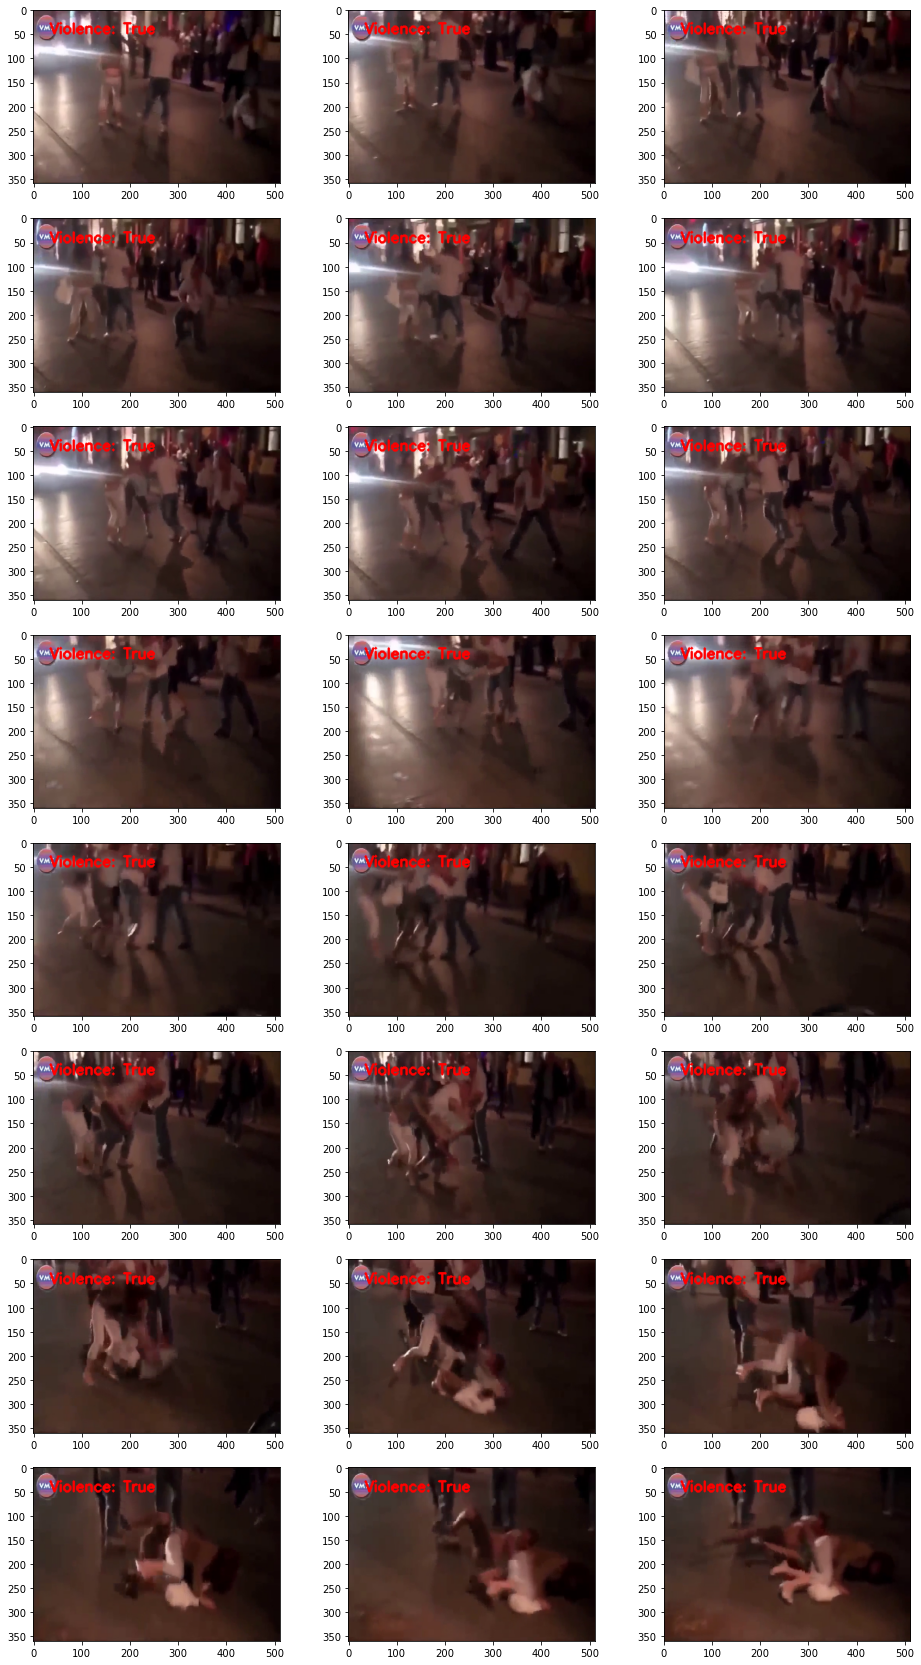

Cleaning up...


In [88]:
print_results(Violence, limit=30)

In [94]:
NonViolence=r"C:\Users\amaan\OneDrive\Desktop\Data/NonViolence/NV_310.mp4"
play(NonViolence)

Loading model ...
1/1 [==============================] - 0s 90ms/step


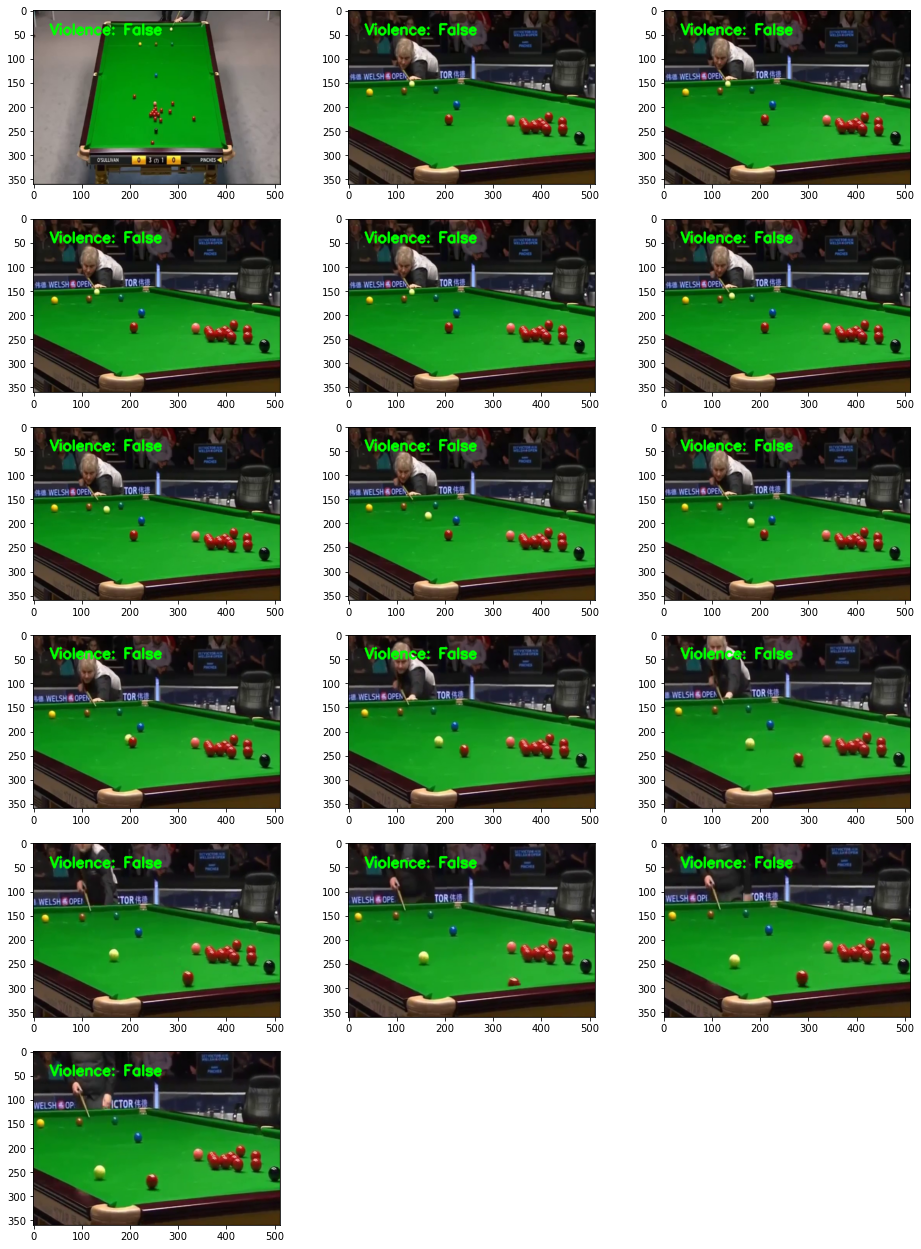

Cleaning up...


In [95]:
print_results(NonViolence, limit=30)

In [91]:
from IPython.display import FileLink
FileLink(r'./model.h5')

C:\Users\amaan\model.h5

## Conclusion : Thus, we have constructed a way to detect violence using MobileNetV2 from surveillance system CCTV footage. This can be further implemeted in surveillance systems where AI based autonomous surveillance is needed.
